# SparseNet with Union Find

Abhinav Madahar <abhinav.madahar@rutgers.edu>, James Abello Monedero <abelloj@cs.rutgers.edu>

---

We speed up the SparseNet algorithm using union find.
Our new algorithm is:
```
Algorithm FastSparseNet(edges: generator, k: int) -> graph:
    OverallSparseNet <- empty graph
    While edges are not exhausted:
        Read 2^k edges into a list E
        Run union find on E to find the connected components
        For each connected component:
            Run the original SparseNet algorithm on the connected component
            Insert into the SparseNet |V| (log |V| - 1) edges from the original connected component which weren't included 
            Save this SparseNet
        For each combination of SparseNets S_i, S_j (excluding reverses so we don't consider (S_j, S_i)):
            Allow up to log(V_1 + V_2) edges to connect S_i and S_j
        Add newly linked SparseNets to OverallSparseNet
    Return OverallSparseNet
```

OK. Let's create a sample graph.

In [2]:
import networkx as nx

G = nx.gnm_random_graph(2 ** 10, 16 * 2 ** 10)

Now, we want to create a function to run the algorithm.

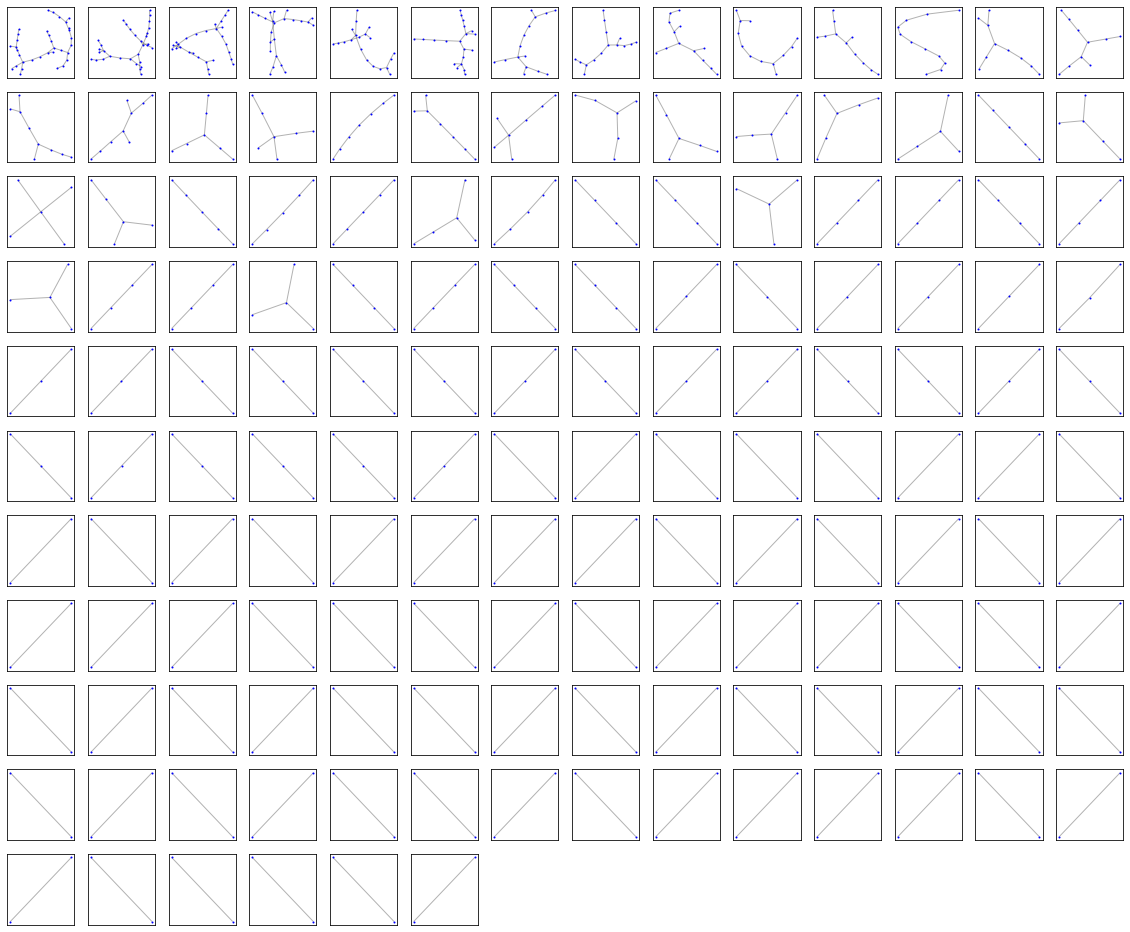

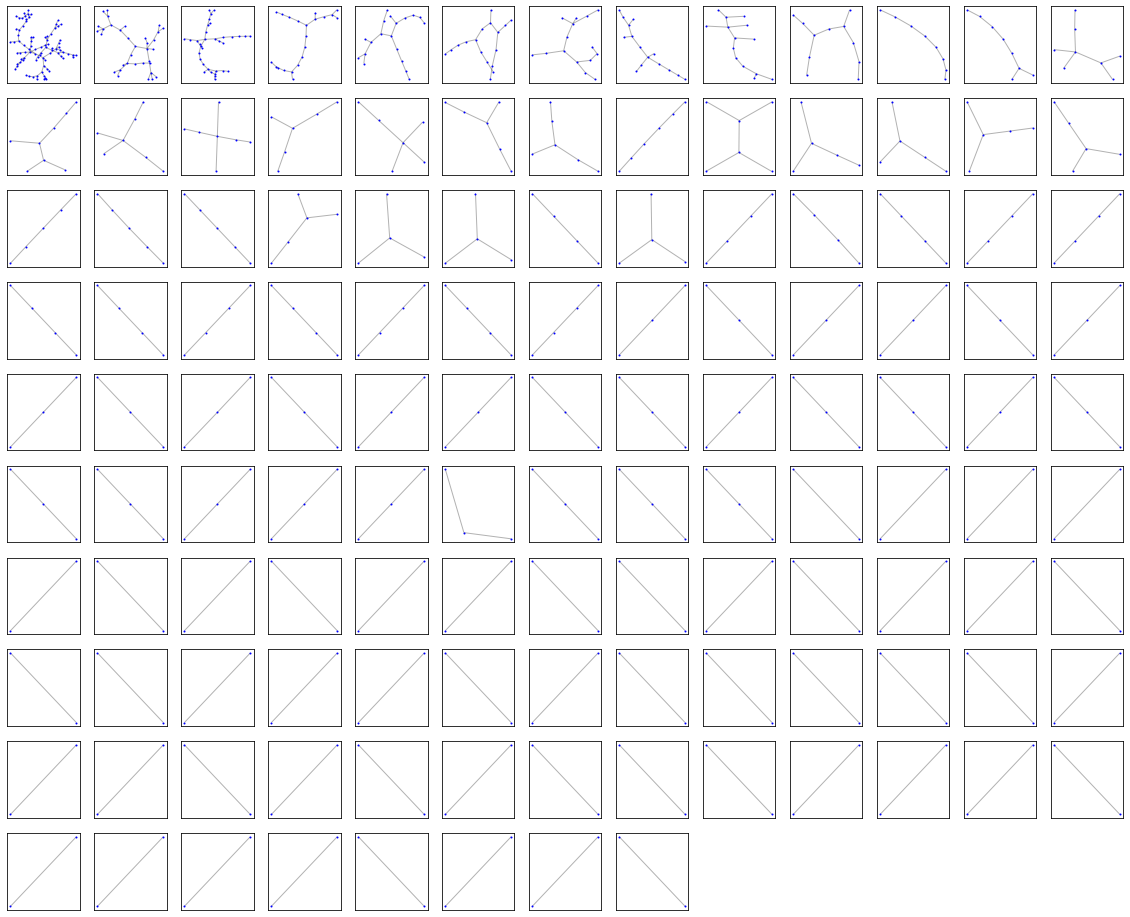

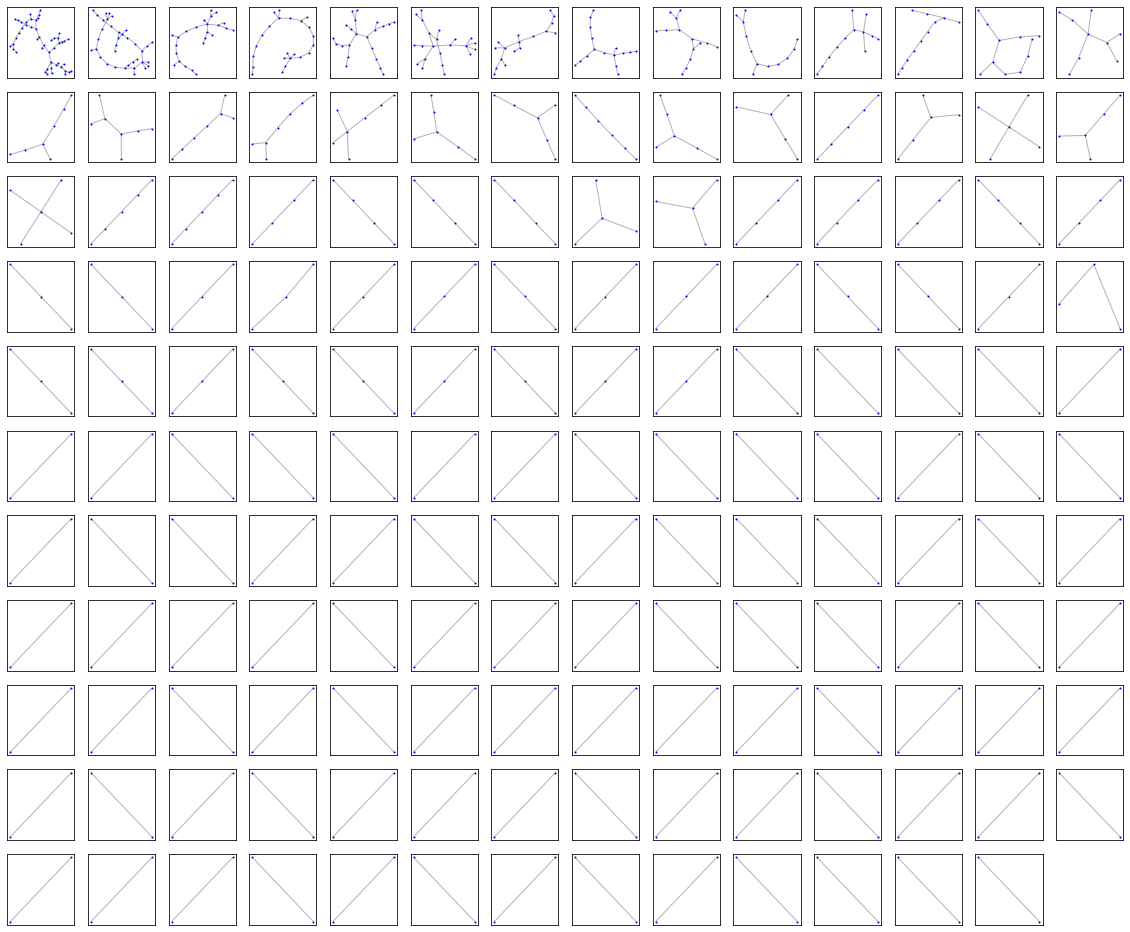

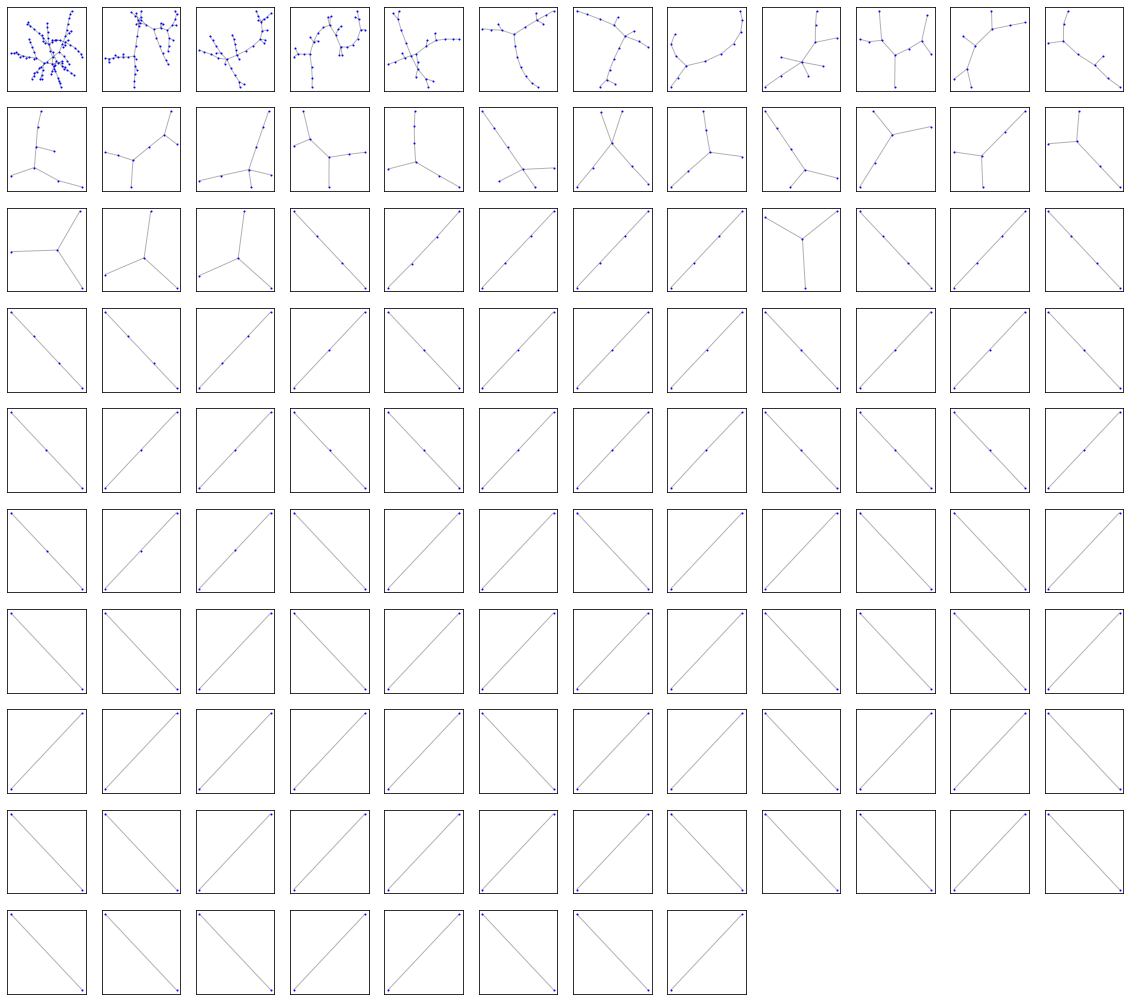

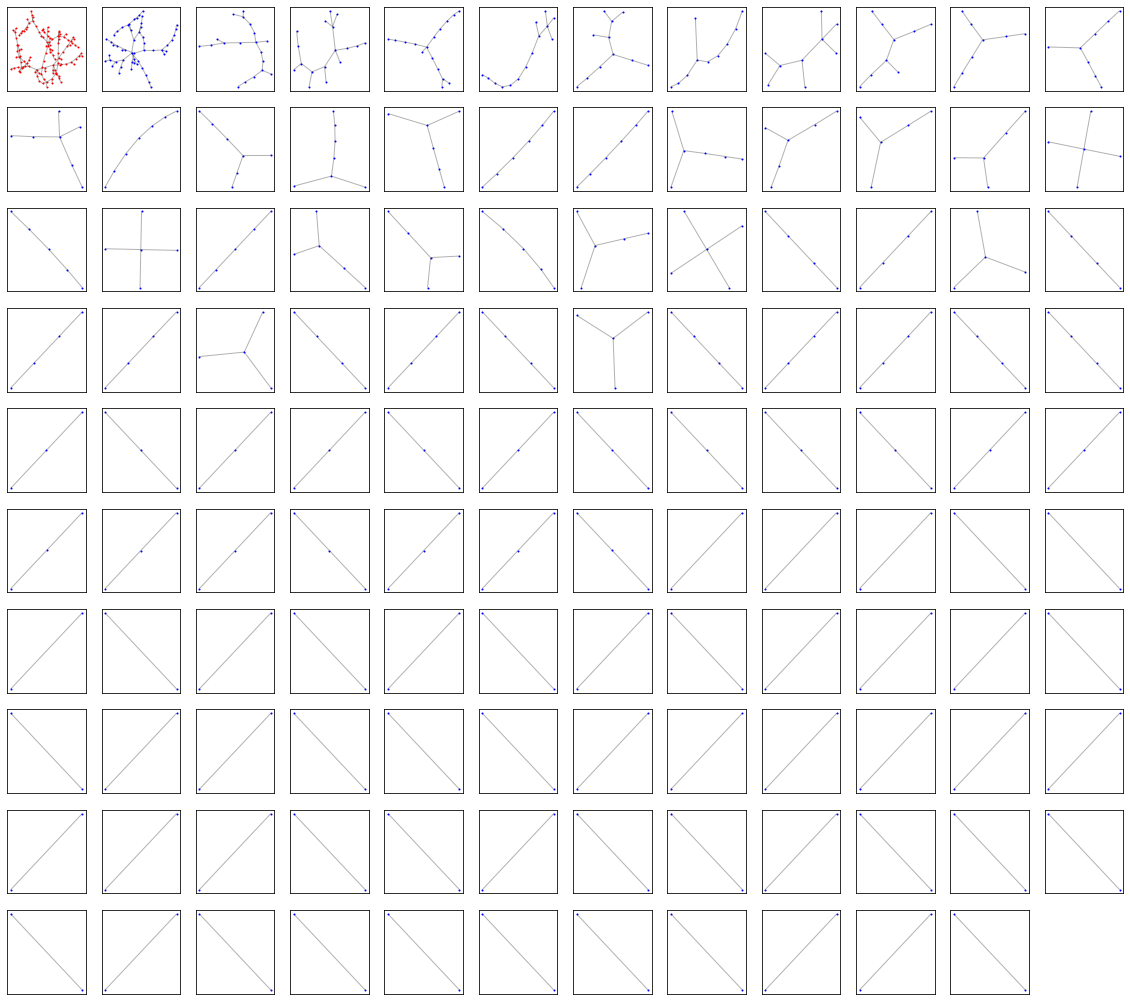

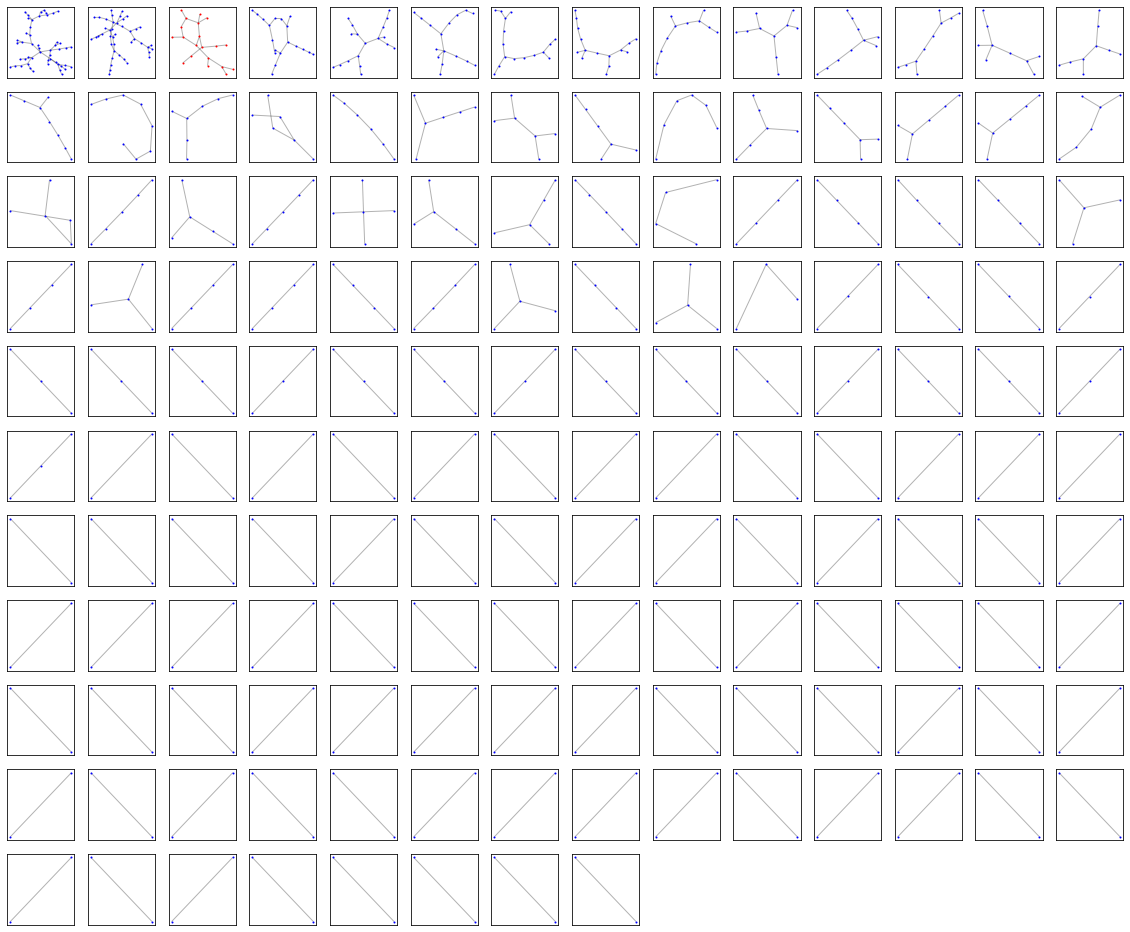

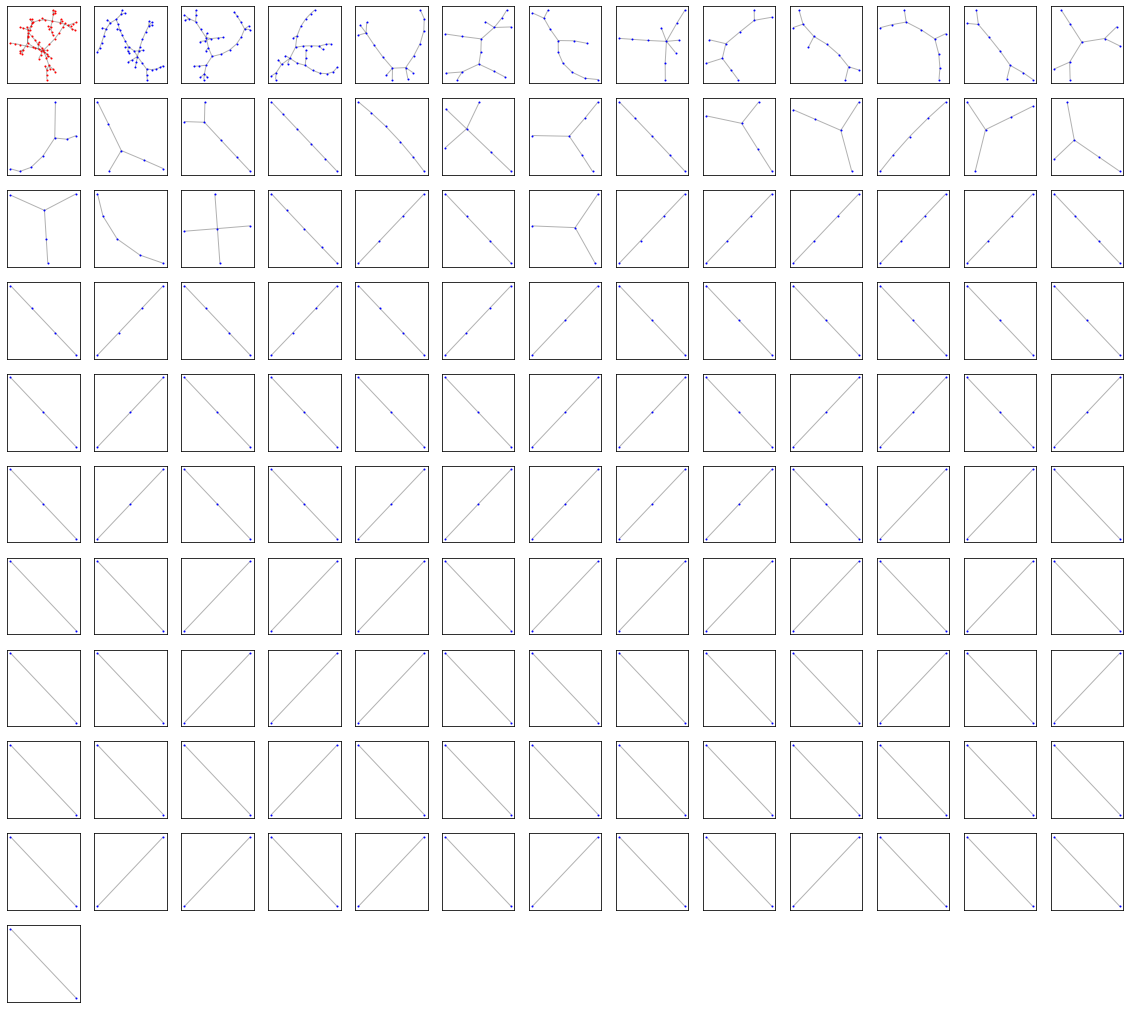

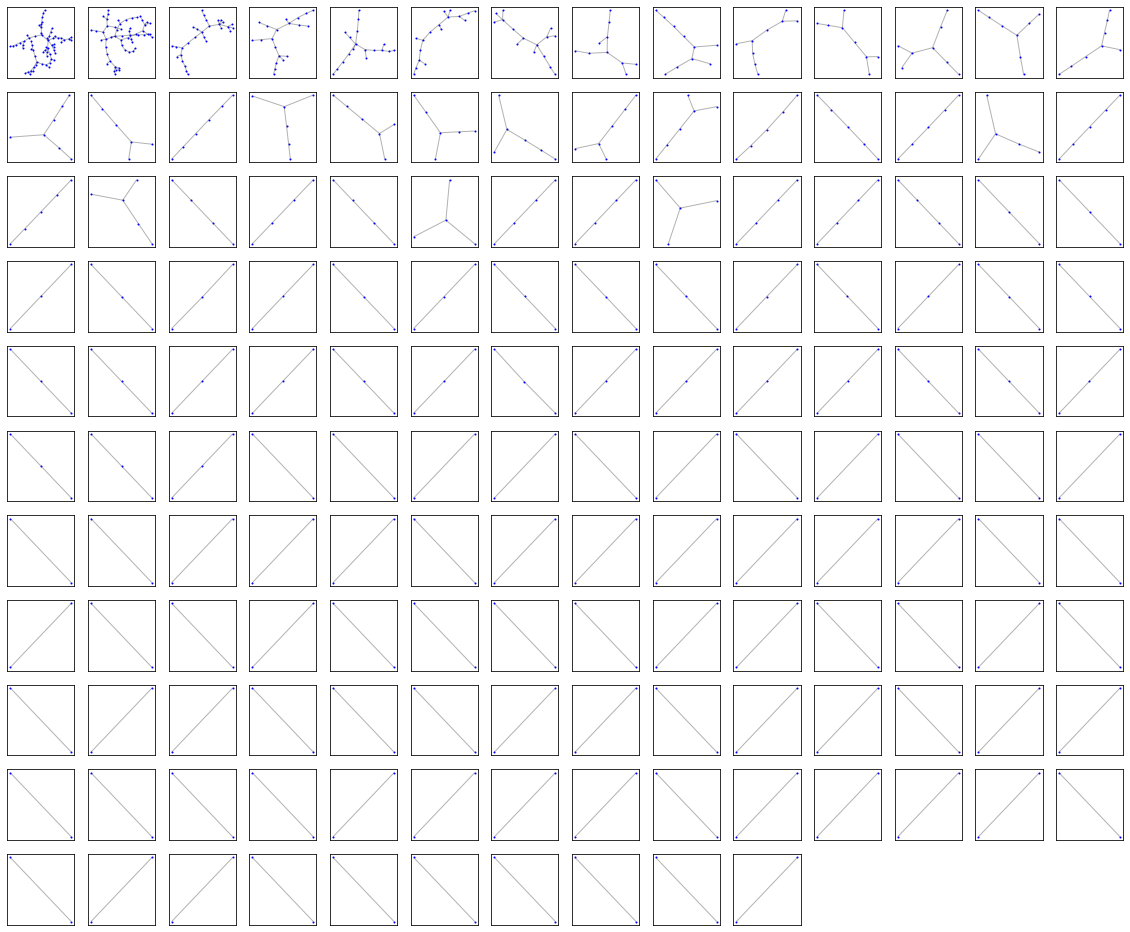

In [57]:
import itertools
import matplotlib.pyplot as plt
from unionfind import UnionFind  # by GitHub user deehzee
from graph.sparsenet import sparsenet
from functools import reduce
import random
import math

def fast_sparsenet(edges_source, k:int = 9) -> nx.Graph:
    overall_sparsenet = nx.Graph()
    while True:
        sparsenets = []
        uf = UnionFind()
        edges = list(itertools.islice(edges_source, 2 ** k))
        if len(edges) == 0:
            return overall_sparsenet
        
        g = nx.empty_graph()
        for src, dest in edges:
            uf.union(src, dest)
            g.add_edge(src, dest)
        
        for i, component in enumerate(uf.components()):
            h = g.subgraph(component)
            distance_matrix = nx.floyd_warshall_numpy(h)
            sn_generator = sparsenet(h, distance_matrix, { node:i for i, node in enumerate(h.nodes()) })
            edges_included_in_sn = set(sum(([(src, dest) for src, dest in zip(path, path[1:])] for path in sn_generator), []))
            leftover = set(h.edges()) - edges_included_in_sn
            extras_wanted = int(h.number_of_nodes() * (math.log2(h.number_of_nodes()) - 1)) + 1
            extra_edges = random.sample(leftover, min(extras_wanted, len(leftover)))
            sparsenets.append(h.edge_subgraph(set(extra_edges) | edges_included_in_sn))

        plt.figure(figsize=(20, 20))
        plt.title('SparseNets of different components')
        for i, sn in enumerate(sorted(sparsenets, key=lambda sn: -sn.number_of_nodes())):
            plt.subplot(int(len(sparsenets) ** 0.5) + 1, int(len(sparsenets) ** 0.5 + 1) + 1, i+1)
            pos = nx.spring_layout(sn)
            nx.draw_networkx_nodes(sn, pos=pos, node_size=1, node_color='blue' if nx.is_tree(sn) else 'red')
            nx.draw_networkx_edges(sn, pos=pos, alpha=0.3)
        plt.show()
        
        original_n = overall_sparsenet.number_of_nodes()
        overall_sparsenet = reduce(nx.compose, sparsenets, overall_sparsenet)
        new_n = overall_sparsenet.number_of_nodes()
        if original_n == new_n:
            return overall_sparsenet


edges = list(G.edges())
random.shuffle(edges)
generated_sparsenet = fast_sparsenet(iter(edges))

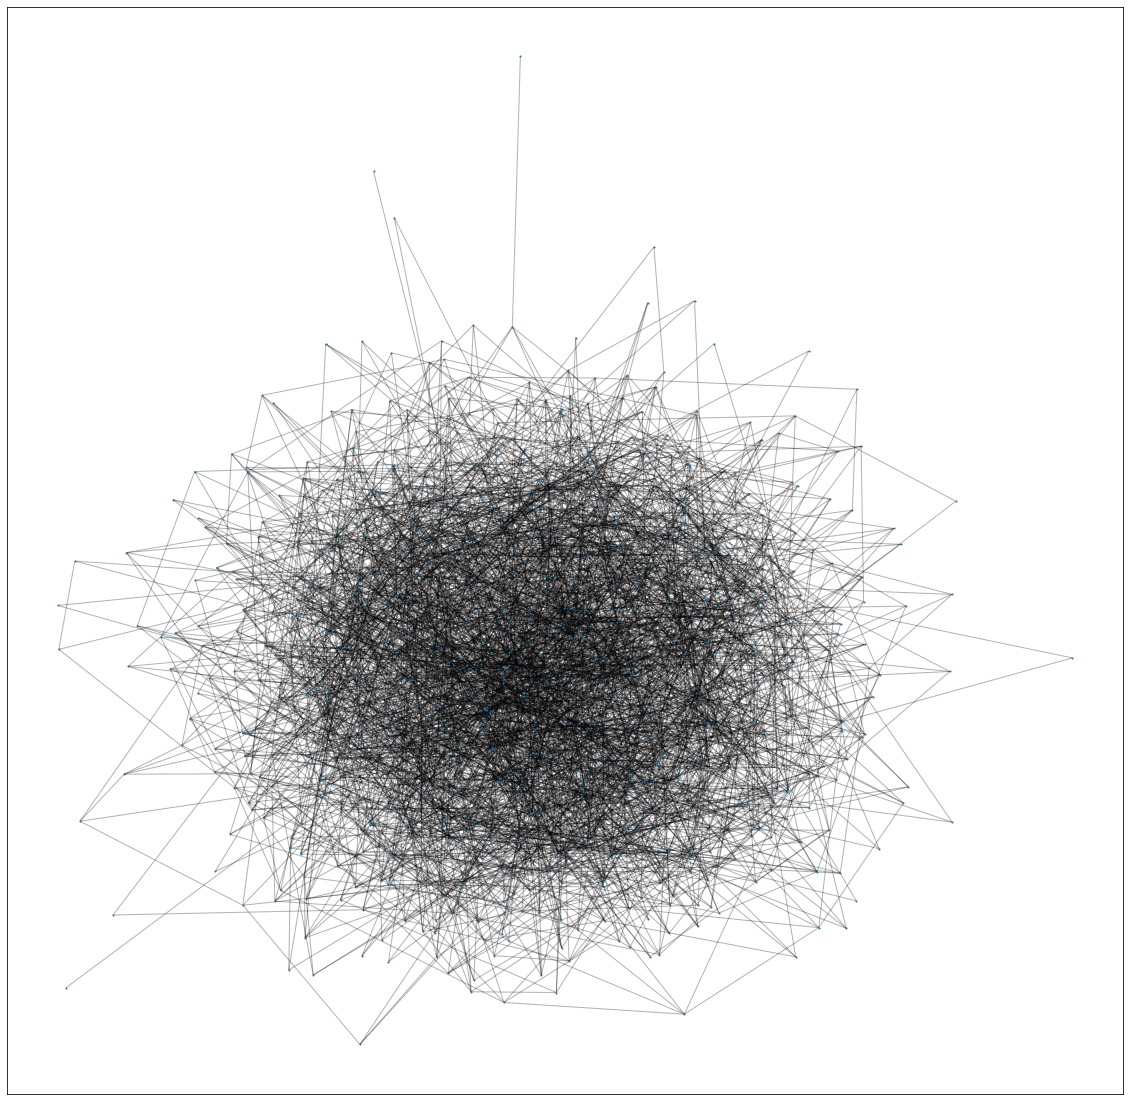

In [17]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(generated_sparsenet)
nx.draw_networkx_nodes(generated_sparsenet, pos=pos, node_size=1)
nx.draw_networkx_edges(generated_sparsenet, pos=pos, alpha=0.3);